#**Introduction**

Name : Rahardiansyah Fatoni

Batch : RMT-027

Objective : To create a clustering model for coutnries segmentation, to see which ones have the lowest living cost.


---



##1. Data Loading and Exploration
- Load Libraries and Dependencies
- Load Dataset
- Understand the Data (head(), info(), describe())
- Check for Missing Values
- Visualize Data (matplotlib, seaborn)

###1.1 Load Libraries and Dependencies:

In [257]:
# Import necessary libraries
import pandas as pd
import numpy as np
from google.colab import auth
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Preprocessing libraries
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#Model saving
import pickle, joblib
import json

###1.2 Load Dataset:

In [258]:
df = pd.read_csv("/content/living-index-and-internet-prices.csv")

###1.3 Data Filtering

In [259]:
df

,Unnamed: 0,Country,Country code,Continental Region,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Number of Internet Plans,Average Price per 1GB (USD),Cheapest Price per 1GB (USD),Most Expensive Price per 1GB (USD),Internet Users,Population
0,0,Afghanistan,AF,ASIA (EX. NEAR EAST),20.37,2.72,14.92,12.41,23.04,35.0,1.02,0.38,2.12,"4,068,194","37,171,921"
1,1,Albania,AL,EASTERN EUROPE,35.50,8.47,29.32,25.82,30.19,32.0,2.80,0.72,96.39,"2,105,339","2,882,740"
2,2,Algeria,DZ,NORTHERN AFRICA,26.87,4.59,28.82,14.48,24.63,20.0,0.51,0.16,2.24,"26,350,000","42,228,408"
3,3,Argentina,AR,SOUTH AMERICA,34.69,7.71,28.17,33.32,30.72,28.0,2.38,0.44,11.47,"33,561,876","44,361,150"
4,4,Armenia,AM,CIS (FORMER USSR),33.89,11.61,27.59,30.55,28.86,21.0,0.76,0.22,13.02,"2,043,110","2,951,745"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,Uruguay,UY,SOUTH AMERICA,52.07,13.93,44.01,49.39,30.07,35.0,1.51,0.10,6.33,"2,360,269","3,449,285"
133,133,Uzbekistan,UZ,CIS (FORMER USSR),27.31,9.29,26.83,24.22,22.37,60.0,0.60,0.01,23.75,"16,692,456","32,476,244"
134,134,Vietnam,VN,ASIA (EX. NEAR EAST),37.48,13.22,38.70,19.98,29.38,46.0,0.49,0.07,5.55,"68,172,134","95,545,962"
135,135,Yemen,YE,NEAR EAST,53.14,6.71,67.12,24.74,14.41,17.0,15.98,0.40,39.94,"7,548,512","28,498,683"


In [260]:
# Display basic information about the dataset (columns, data types, non-null counts)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          137 non-null    int64  
 1   Country                             137 non-null    object 
 2   Country code                        137 non-null    object 
 3   Continental Region                  137 non-null    object 
 4   Cost of Living Index                137 non-null    float64
 5   Rent Index                          137 non-null    float64
 6   Groceries Index                     137 non-null    float64
 7   Restaurant Price Index              137 non-null    float64
 8   Local Purchasing Power Index        137 non-null    float64
 9   Number of Internet Plans            137 non-null    float64
 10  Average Price per 1GB (USD)         137 non-null    float64
 11  Cheapest Price per 1GB (USD)        137 non-n

$Insight:$
- There are 137 customer credit data entries with 0 null values detected on any of the variables, besides `Internet Users` and `Population`
- Some variables seems to have the wrong datatypes (`Population`, `Internet Users`)
- The variable `Unnamed: 0` will be removed as it seems to be the same values as the index.
- The variable `Cheapest Price per 1GB (USD)` and `Most Expensive Price per 1GB (USD)` will be removed to avoid multicollinierity with `Average Price per 1GB (USD)`
- The variable `Number of Internet Plans` will be removed since it is deemed redundant, and might add to an overfitted model.
- The variable `Internet Users` will also be dropped since it seems redundant to try and get a correlation of cost of living and internet users.

In [261]:
df = df.drop('Unnamed: 0', axis= 1).drop("Cheapest Price per 1GB (USD)", axis=1).drop("Most Expensive Price per 1GB (USD)", axis=1).drop("Number of Internet Plans",axis=1).drop("Internet Users", axis=1)

In [262]:
df = df.dropna()

In [263]:
df['Population'] = df['Population'].str.replace(",", "").astype(int)

In [264]:
# Display summary statistics of numerical columns
print(df.describe())

       Cost of Living Index  Rent Index  Groceries Index  \
count            132.000000  132.000000       132.000000   
mean              49.649394   18.713106        46.281591   
std               20.663027   14.568580        20.989753   
min               19.920000    2.720000        14.920000   
25%               34.662500    9.552500        31.105000   
50%               44.225000   14.190000        39.980000   
75%               59.860000   23.430000        55.372500   
max              146.040000   98.580000       148.660000   

       Restaurant Price Index  Local Purchasing Power Index  \
count              132.000000                    132.000000   
mean                42.669091                     45.925909   
std                 24.551057                     26.844629   
min                 12.410000                      1.450000   
25%                 25.225000                     27.150000   
50%                 33.820000                     35.655000   
75%               

---
$Insight:$
- From the dataset schema:
> Column-column dibawah ini menandakan semakin tinggi nilainya, maka biaya yang dibutuhkan semakin besar di negara tersebut.

> - Cost of Living Index
> - Rent Index
> - Groceries Index
> - Restaurant Price Index
> - Local Purchasing Power Index

---
Filtering done : removed unused columns, fixed columns datatypes, and dropped NaN values since the entries with missing values are only a fraction of the entire dataset.

###1.4 Visualize the data

In [265]:
df

,Country,Country code,Continental Region,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Average Price per 1GB (USD),Population
0,Afghanistan,AF,ASIA (EX. NEAR EAST),20.37,2.72,14.92,12.41,23.04,1.02,37171921
1,Albania,AL,EASTERN EUROPE,35.50,8.47,29.32,25.82,30.19,2.80,2882740
2,Algeria,DZ,NORTHERN AFRICA,26.87,4.59,28.82,14.48,24.63,0.51,42228408
3,Argentina,AR,SOUTH AMERICA,34.69,7.71,28.17,33.32,30.72,2.38,44361150
4,Armenia,AM,CIS (FORMER USSR),33.89,11.61,27.59,30.55,28.86,0.76,2951745
...,...,...,...,...,...,...,...,...,...,...
132,Uruguay,UY,SOUTH AMERICA,52.07,13.93,44.01,49.39,30.07,1.51,3449285
133,Uzbekistan,UZ,CIS (FORMER USSR),27.31,9.29,26.83,24.22,22.37,0.60,32476244
134,Vietnam,VN,ASIA (EX. NEAR EAST),37.48,13.22,38.70,19.98,29.38,0.49,95545962
135,Yemen,YE,NEAR EAST,53.14,6.71,67.12,24.74,14.41,15.98,28498683


In [266]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132 entries, 0 to 136
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       132 non-null    object 
 1   Country code                  132 non-null    object 
 2   Continental Region            132 non-null    object 
 3   Cost of Living Index          132 non-null    float64
 4   Rent Index                    132 non-null    float64
 5   Groceries Index               132 non-null    float64
 6   Restaurant Price Index        132 non-null    float64
 7   Local Purchasing Power Index  132 non-null    float64
 8   Average Price per 1GB (USD)   132 non-null    float64
 9   Population                    132 non-null    int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 11.3+ KB


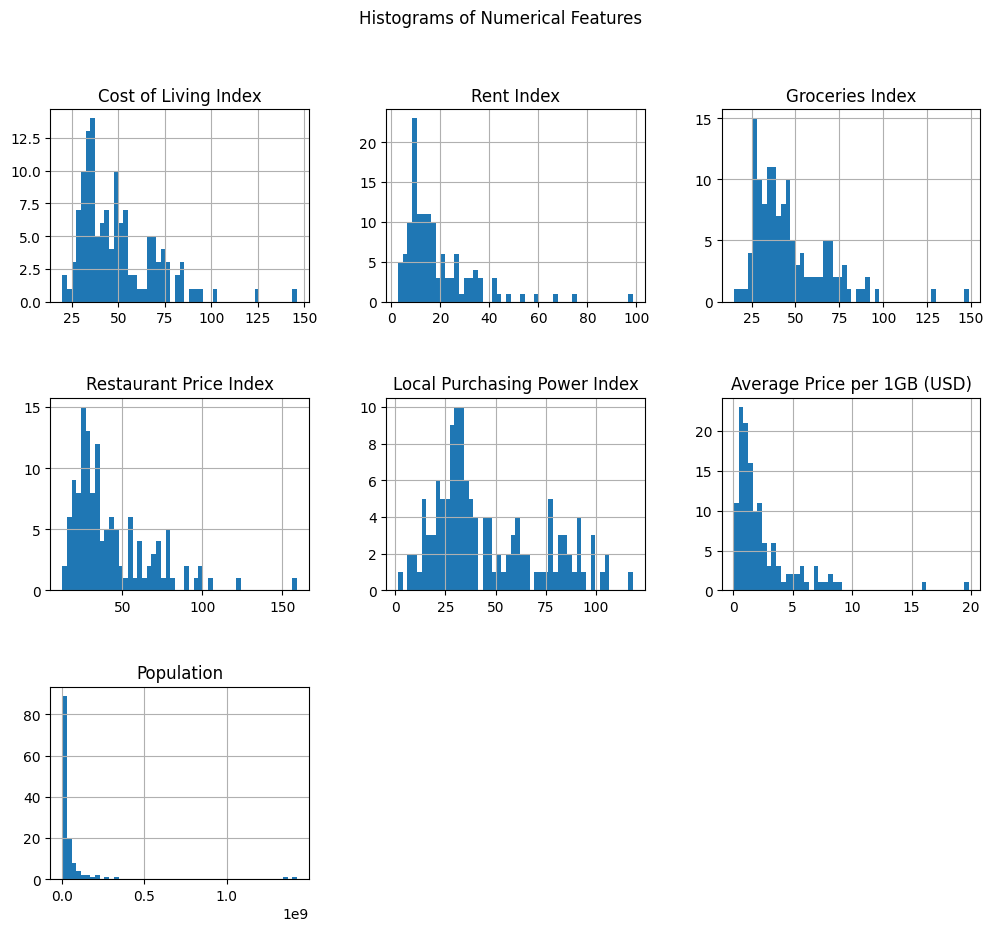

In [267]:
# Visualize the distribution of numerical features (histograms)
df.hist(bins=50, figsize=(12, 10))
plt.suptitle('Histograms of Numerical Features')
plt.subplots_adjust(hspace=0.5)
plt.show()

In [268]:
# Calculate skewness for each column
skewness = df.skew()

# Display skewness values
print("Skewness for each column:")
print(skewness)

Skewness for each column:
Cost of Living Index            1.522425
Rent Index                      2.413934
Groceries Index                 1.767580
Restaurant Price Index          1.646303
Local Purchasing Power Index    0.734111
Average Price per 1GB (USD)     3.185901
Population                      6.991657
dtype: float64


<ipython-input-268-b0bc8009c479>:2: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  skewness = df.skew()


$Insight:$
- The numerical columns all have either a right skew, or a left skew, therefore we will scale it with either MinMax or Robust scaler.

##2. Feature Engineering

###2.1 Handle Outliers:

In [269]:
numerical_feature = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

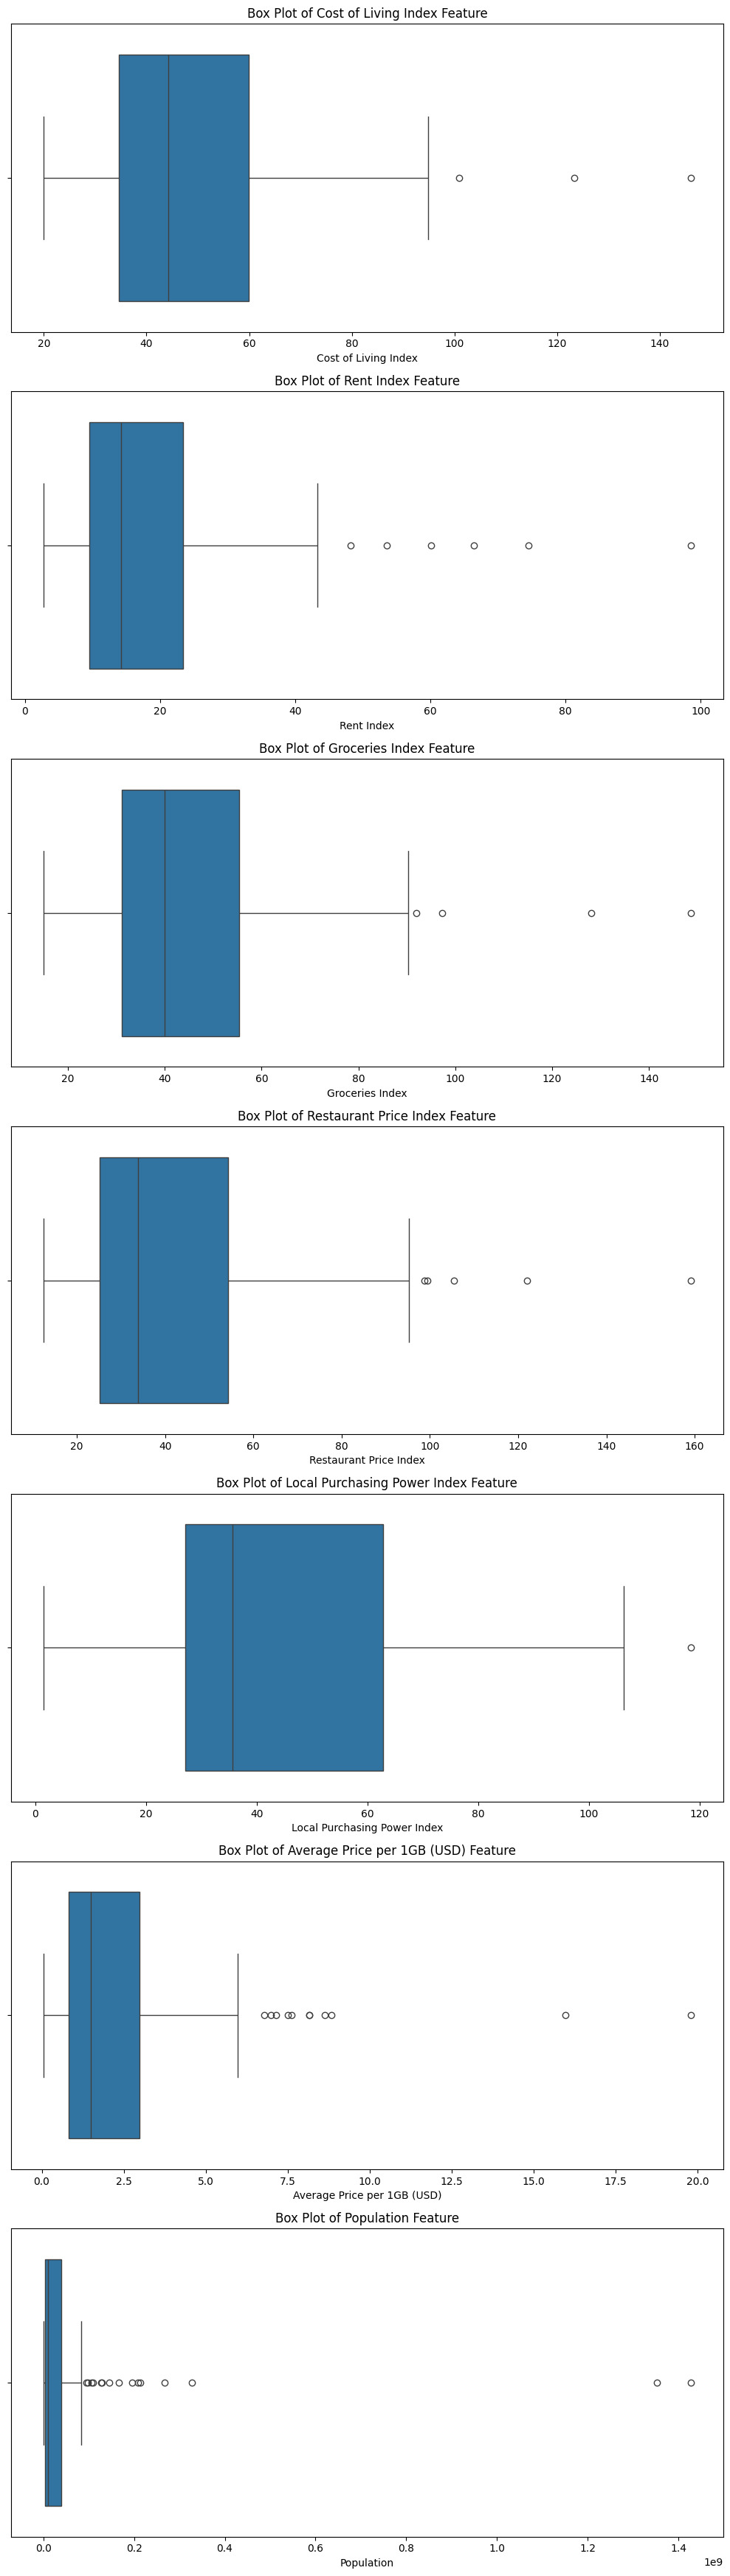

In [270]:
# Using box plot to identify outliers
plt.figure(figsize=(10, 5 * len(numerical_feature)))

for i, feature in enumerate(numerical_feature, 1):
    plt.subplot(len(numerical_feature), 1, i)
    sns.boxplot(x=df[feature])
    plt.title(f'Box Plot of {feature} Feature')

plt.tight_layout()
plt.show()

---
$Insight:$
- It seems that some variables have quite a bit of outliers, therefore we will use RobustScaler to minimize it.

###2.2 Scale or Normalize Features:

In [271]:
df_scaled = df.drop("Country", axis=1).drop("Country code", axis=1).drop("Continental Region", axis=1)

In [272]:
# Scale using robustscaler to handle outliers
scaler = RobustScaler()
numerical_columns = df_scaled.select_dtypes(include=['int64', 'float64']).columns
df_scaled[numerical_columns] = scaler.fit_transform(df[numerical_columns])

###2.3 Dimensionality Reduction:

In [273]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132 entries, 0 to 136
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Cost of Living Index          132 non-null    float64
 1   Rent Index                    132 non-null    float64
 2   Groceries Index               132 non-null    float64
 3   Restaurant Price Index        132 non-null    float64
 4   Local Purchasing Power Index  132 non-null    float64
 5   Average Price per 1GB (USD)   132 non-null    float64
 6   Population                    132 non-null    float64
dtypes: float64(7)
memory usage: 8.2 KB


In [274]:
# Dimensionality Reduction using PCA
pca = PCA()
pca.fit(df_scaled)

PCA()

Text(0, 0.5, 'Eigenvalues')

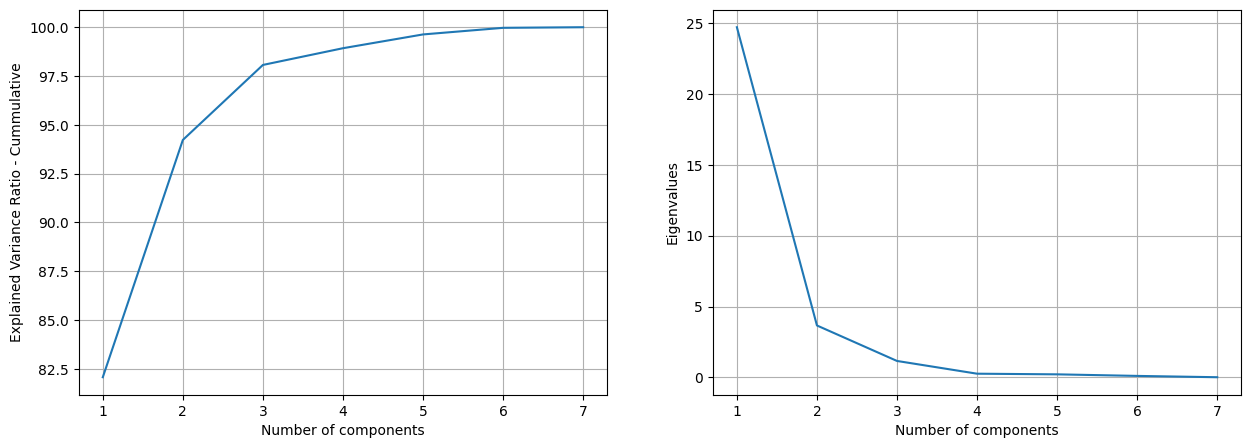

In [275]:
# Plot the Cummulative of Explained Variance Ratio
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(range(1, 8), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio - Cummulative')

# Plot the Eigenvalues
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(range(1, 8), pca.explained_variance_ )
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')

In [276]:
# Check the number of features if we want to retain 95 % of the information

cumsum = np.cumsum(pca.explained_variance_ratio_)
num_features = np.argmax(cumsum >= 0.95) + 1
num_features

3

In [277]:
# Let's train the model with 95 % of the original dataset information

pca = PCA(n_components=0.95)
pca.fit(df_scaled)

df_scaled_pca = pca.transform(df_scaled)

##3. Model Definition & Training

### 3.1 Find the Optimal Number of Clusters

#####Using Elbow Method

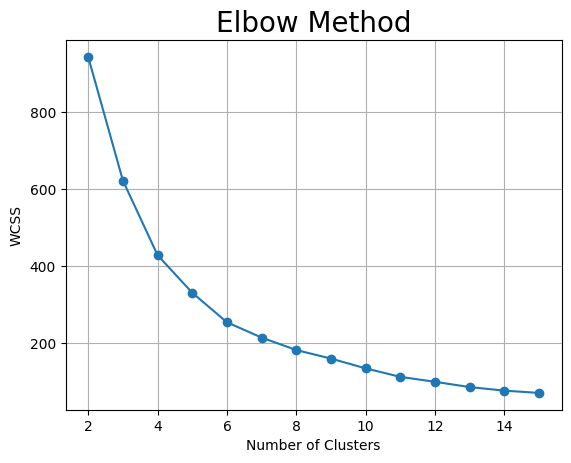

In [278]:
# Find the optimal number of clusters using Elbow Method
wcss = []
random_state = 10
max_cluster = 15
for i in range(2, max_cluster+1):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = random_state)
    km.fit(df_scaled_pca)
    wcss.append(km.inertia_)

plt.plot(range(2, max_cluster+1), wcss, marker ="o")
plt.grid()
plt.title('Elbow Method', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

---
$Insight:$
- Based on the plot, the location of the elbow is in cluster 5.

#####Using Silhoutte Plot & Silhoutte Score

Next, we will find the silhouette score and silhouette plot. The following code is taken from [Scikit-Learn documentation page](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)

In [279]:
# Function to create Silhouette Plot

import matplotlib.cm as cm
from sklearn.metrics import silhouette_score,silhouette_samples

def plot_silhouette(range_n_clusters, X, random_state):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_

        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

For n_clusters = 2 The average silhouette_score is : 0.9194411705172
For n_clusters = 3 The average silhouette_score is : 0.4619758406071515
For n_clusters = 4 The average silhouette_score is : 0.4947746629365398
For n_clusters = 5 The average silhouette_score is : 0.4835123399793225
For n_clusters = 6 The average silhouette_score is : 0.49492537069950066
For n_clusters = 7 The average silhouette_score is : 0.4466755276087274
For n_clusters = 8 The average silhouette_score is : 0.36573813192778093
For n_clusters = 9 The average silhouette_score is : 0.36808393064126377
For n_clusters = 10 The average silhouette_score is : 0.3763252825861725
For n_clusters = 11 The average silhouette_score is : 0.37174323224133804
For n_clusters = 12 The average silhouette_score is : 0.3756018599543705
For n_clusters = 13 The average silhouette_score is : 0.382219984787743
For n_clusters = 14 The average silhouette_score is : 0.35060199124367636


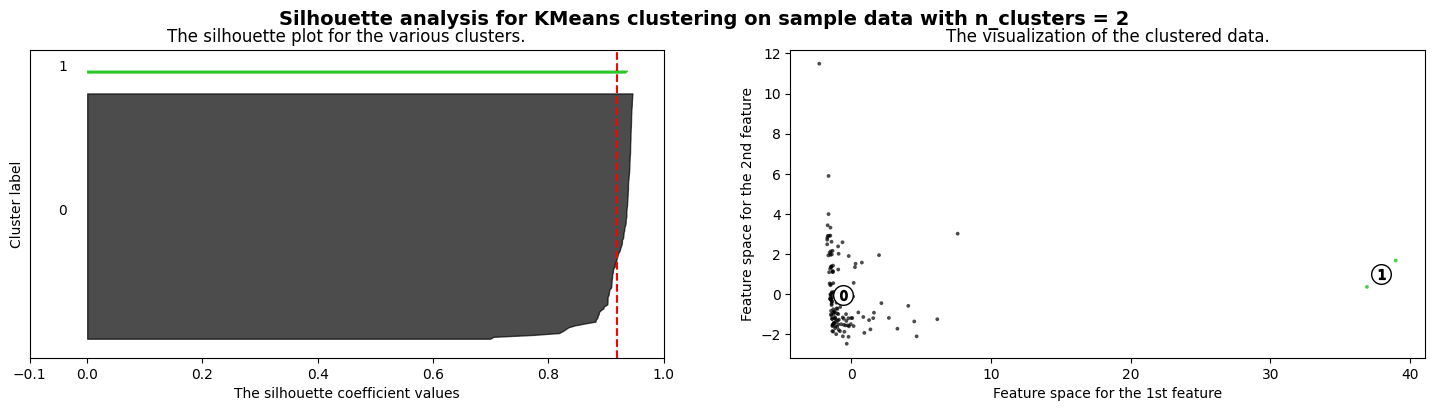

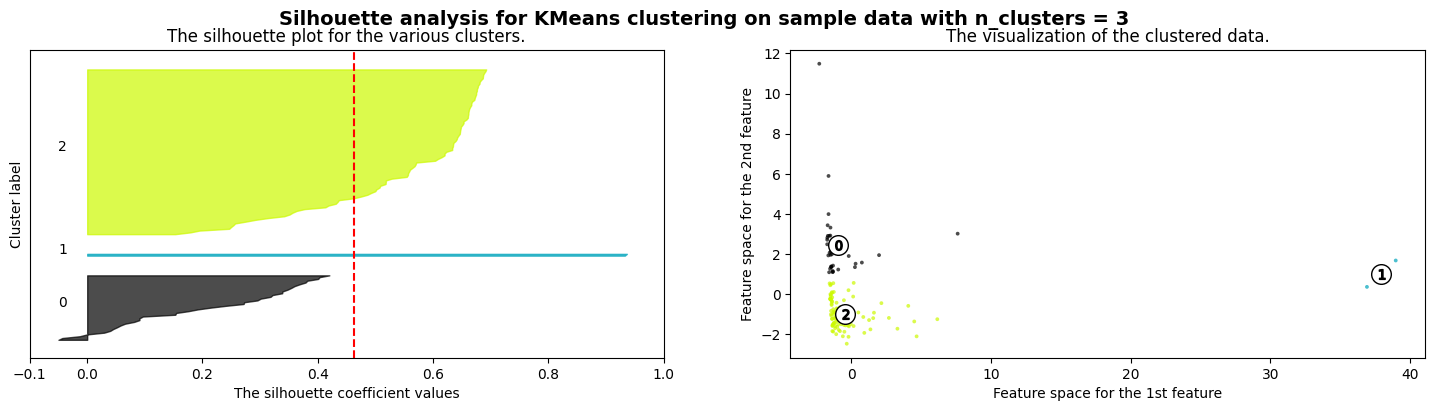

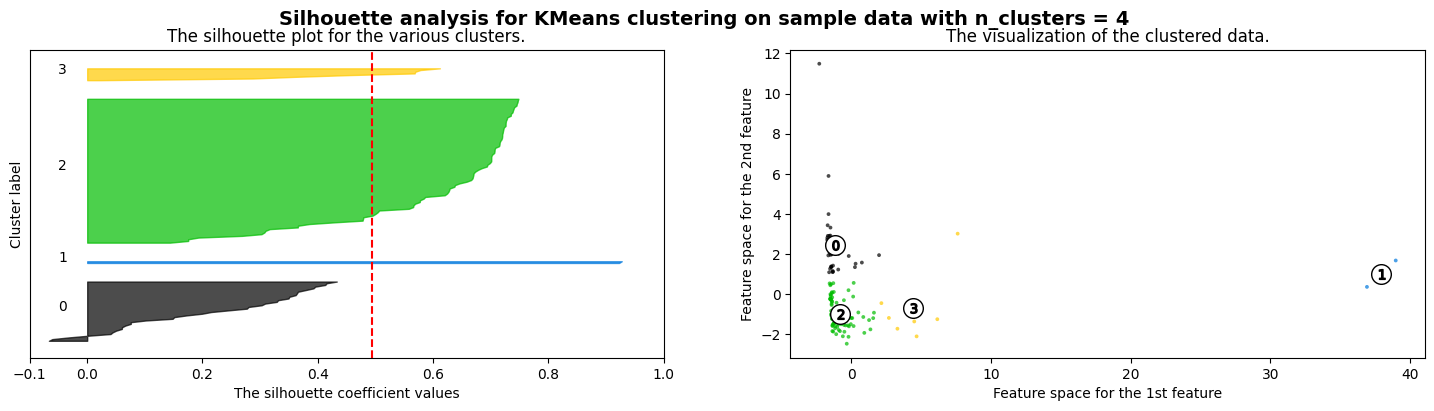

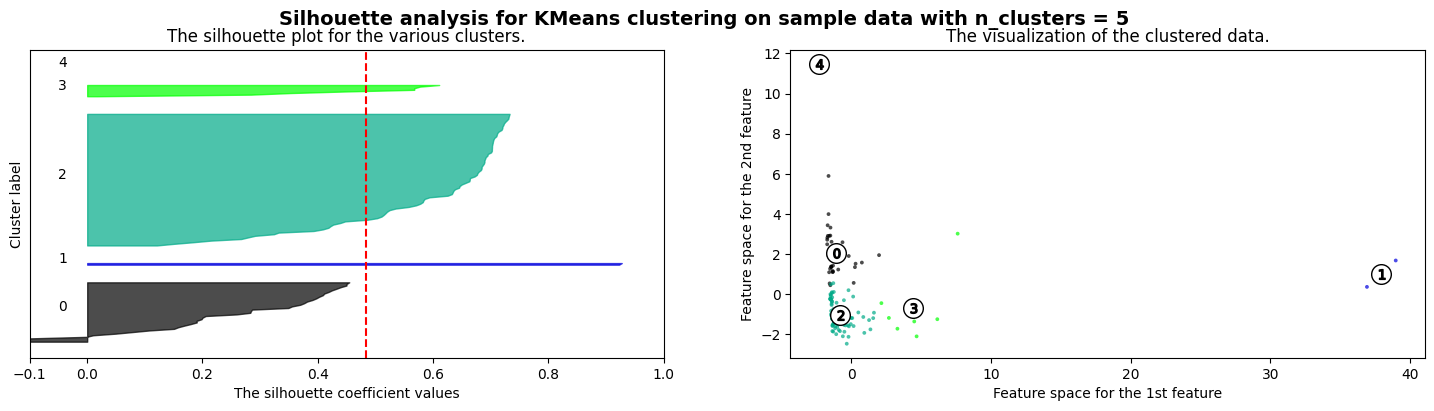

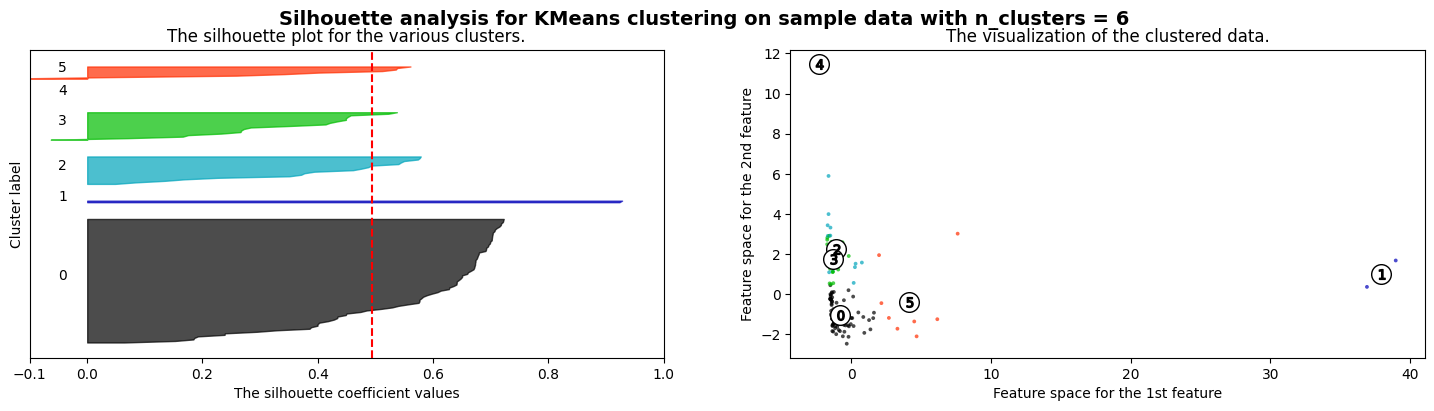

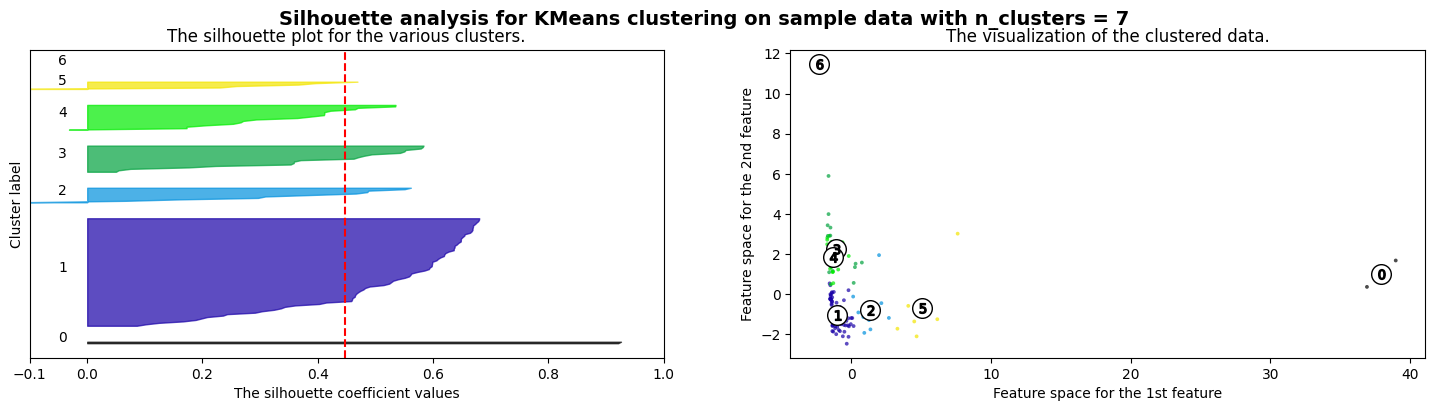

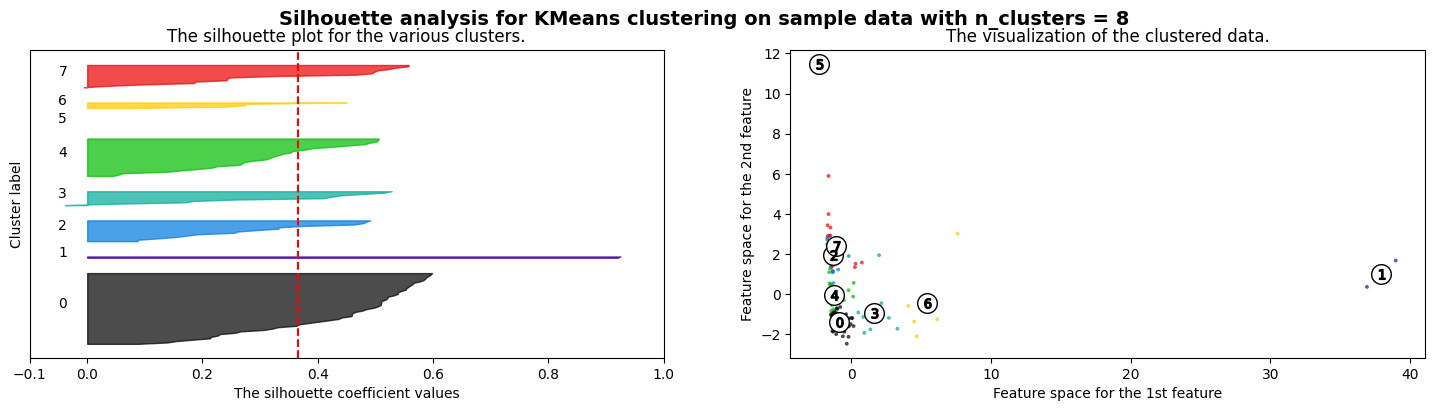

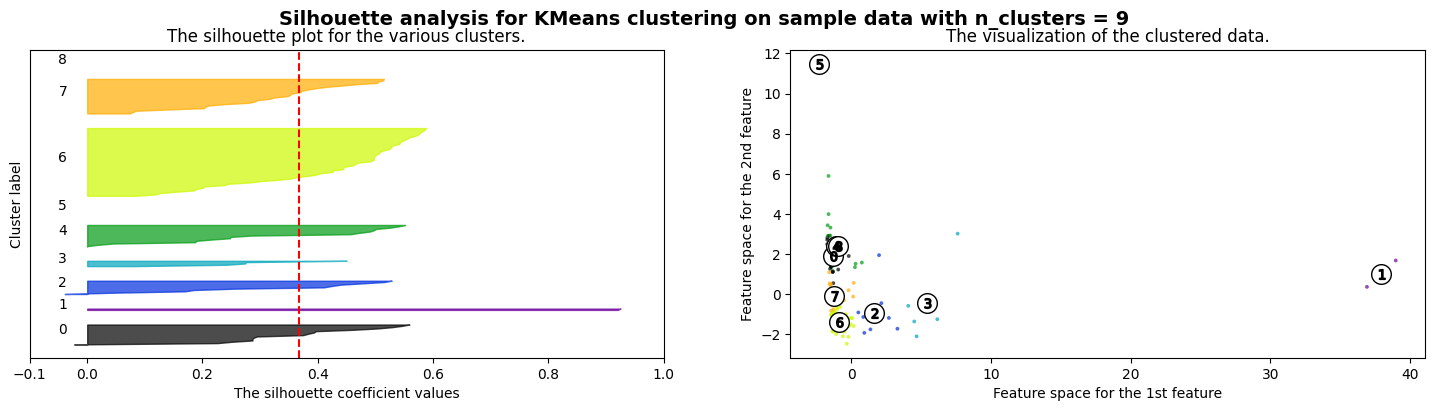

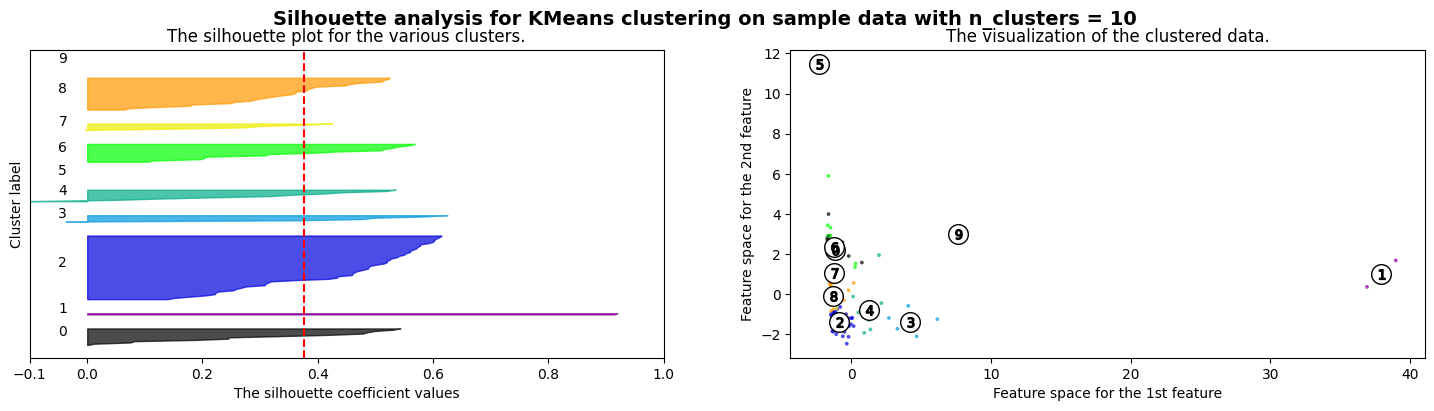

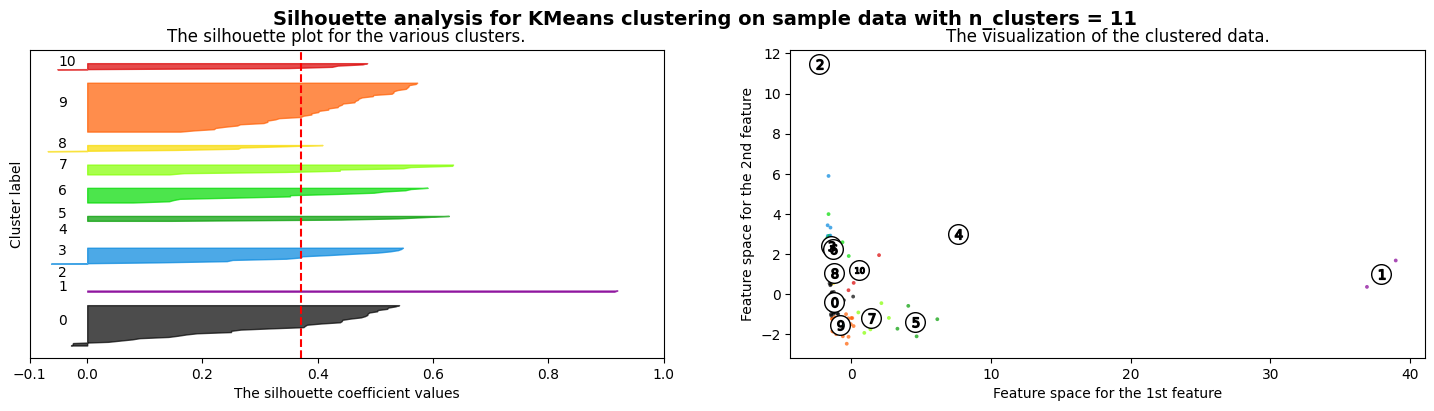

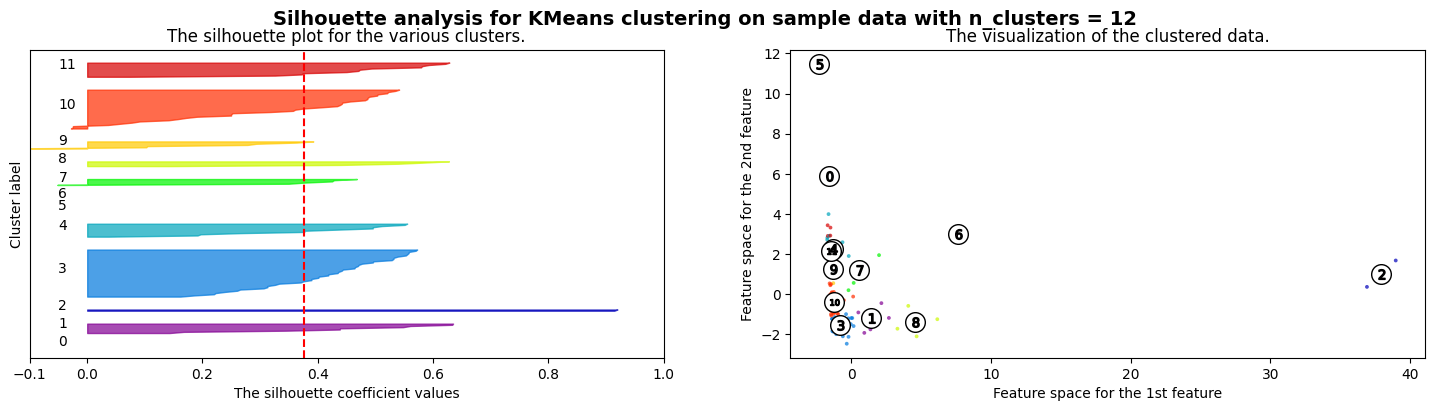

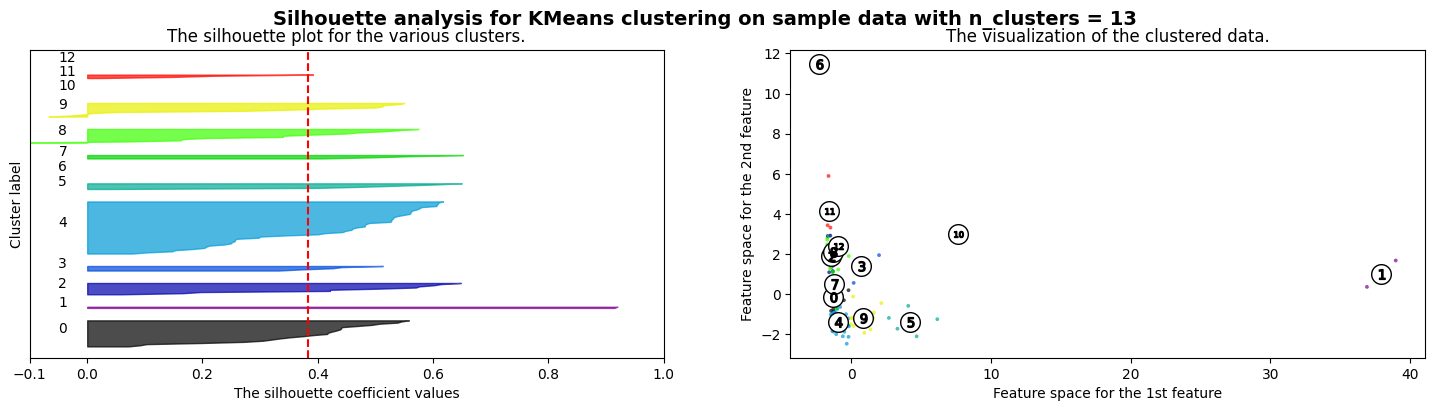

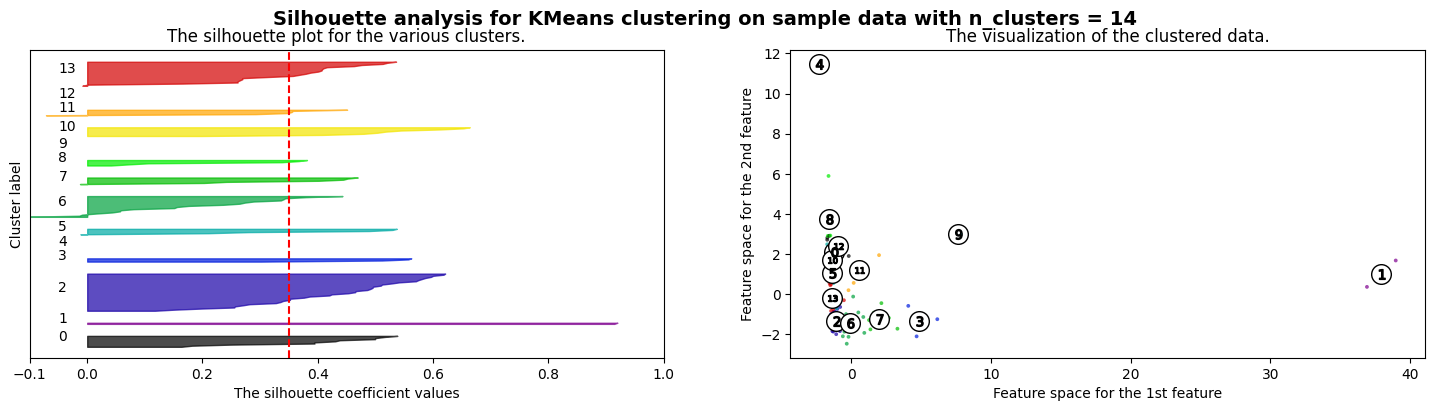

In [280]:
# Display the Silhouette Score and Plot Silhouette Plot

plot_silhouette(range(2, max_cluster), df_scaled_pca, random_state)

---
$Insight:$
- Although `n_cluster=2` yields the highest silhouette score, the data distribution in each cluster appears to be highly imbalanced.
- Using visualization doesn't seem to allow for a clear conclusion to be made, but using `n_cluster=5` that we got from the elbow method, it seems that the clusters are too clustered.
- We shall use `n_cluster=4` since it seems to provide a good visualization and the 2nd highest silhouette score.

###3.2 Train with optimal number of clusters

In [281]:
# Train with optimal number of clusters

km = KMeans(n_clusters = 4, init = 'k-means++', random_state = random_state)
pred = km.fit_predict(df_scaled_pca)
pred

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 3, 0, 2, 0, 2, 0, 2, 2, 2, 3, 2, 2,
       2, 0, 2, 1, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0,
       2, 0, 2, 2, 0, 2, 0, 1, 3, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       0, 0, 2, 2, 0, 2, 2, 0, 2, 3, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2, 0, 2,
       3, 2, 2, 2, 2, 2, 2, 0, 0, 2, 3, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0,
       2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 3, 2, 2, 2, 0, 2],
      dtype=int32)

In [282]:
# Create a new DataFrame with the cluster labels
cluster_df = pd.DataFrame({'cluster': pred}, index=df.index)

# Concatenate the original DataFrame and the cluster labels DataFrame
df = pd.concat([df, cluster_df], axis=1)

In [283]:
# Display the DataFrame with the new 'cluster' column
df

,Country,Country code,Continental Region,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Average Price per 1GB (USD),Population,cluster
0,Afghanistan,AF,ASIA (EX. NEAR EAST),20.37,2.72,14.92,12.41,23.04,1.02,37171921,2
1,Albania,AL,EASTERN EUROPE,35.50,8.47,29.32,25.82,30.19,2.80,2882740,2
2,Algeria,DZ,NORTHERN AFRICA,26.87,4.59,28.82,14.48,24.63,0.51,42228408,2
3,Argentina,AR,SOUTH AMERICA,34.69,7.71,28.17,33.32,30.72,2.38,44361150,2
4,Armenia,AM,CIS (FORMER USSR),33.89,11.61,27.59,30.55,28.86,0.76,2951745,2
...,...,...,...,...,...,...,...,...,...,...,...
132,Uruguay,UY,SOUTH AMERICA,52.07,13.93,44.01,49.39,30.07,1.51,3449285,2
133,Uzbekistan,UZ,CIS (FORMER USSR),27.31,9.29,26.83,24.22,22.37,0.60,32476244,2
134,Vietnam,VN,ASIA (EX. NEAR EAST),37.48,13.22,38.70,19.98,29.38,0.49,95545962,2
135,Yemen,YE,NEAR EAST,53.14,6.71,67.12,24.74,14.41,15.98,28498683,0


---
#After Clustering EDA

<Axes: >

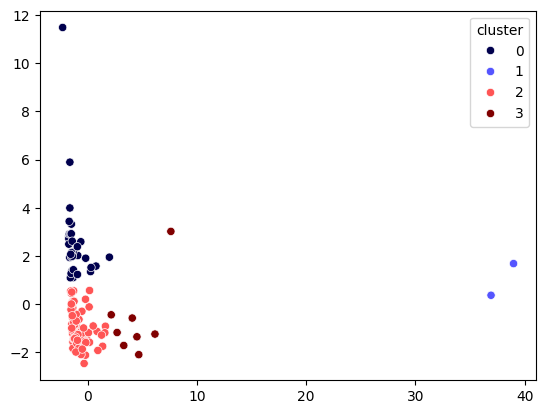

In [284]:
# Cluster visualization in 2D

pca_2d = PCA(n_components=2)
pca_2d.fit(df_scaled)

df_scaled_pca_2d = pca_2d.fit_transform(df_scaled)

sns.scatterplot(x=df_scaled_pca_2d[:,0], y=df_scaled_pca_2d[:,1], hue=df['cluster'], palette='seismic')

In [285]:
num_columns = X.select_dtypes(include='number').columns.tolist()

##Correlation between variables and cluster

In [286]:
#We will use a for loop to get the correlation of each features to the cluster.
for i in num_columns:
    corr_tau, pval_k = stats.kendalltau(X[i], y)

    if pval_k > 0.05:
        print("")
        print(f"- No significant correlation between cluster and {i}")
    else:
        print("")
        print(f"- Significant correlation between cluster and {i}:")
        print(f"  Kendall correlation: {corr_tau:.2f}, p-value: {pval_k}")


- Significant correlation between cluster and Cost of Living Index:
  Kendall correlation: -0.57, p-value: 2.5183245176050334e-16

- Significant correlation between cluster and Rent Index:
  Kendall correlation: -0.49, p-value: 3.0632368459994217e-12

- Significant correlation between cluster and Groceries Index:
  Kendall correlation: -0.56, p-value: 1.0737217297929218e-15

- Significant correlation between cluster and Restaurant Price Index:
  Kendall correlation: -0.51, p-value: 2.564419623429758e-13

- Significant correlation between cluster and Local Purchasing Power Index:
  Kendall correlation: -0.45, p-value: 1.0143430729732746e-10

- Significant correlation between cluster and Average Price per 1GB (USD):
  Kendall correlation: -0.33, p-value: 2.23796918216424e-06

- Significant correlation between cluster and Population:
  Kendall correlation: 0.24, p-value: 0.00044664809083015005


---
$Insight:$

- The features with the highest absolute Kendall correlation coefficients are:

> `Cost of Living Index`:
> - Kendall correlation: -0.57
> - P-value: 2.5183245176050334e-16

> `Groceries Index`:
> - Kendall correlation: -0.56
> - P-value: 1.0737217297929218e-15

- The feature with the highest positive kendall correlation is:

>`Population`:
> - Kendall correlation: 0.24
> - P-value: 0.00044664809083015005

##Visualisation of each cluster's variables

Fist, let's visualize the scatterplot of the two most significant variables to the cluster.

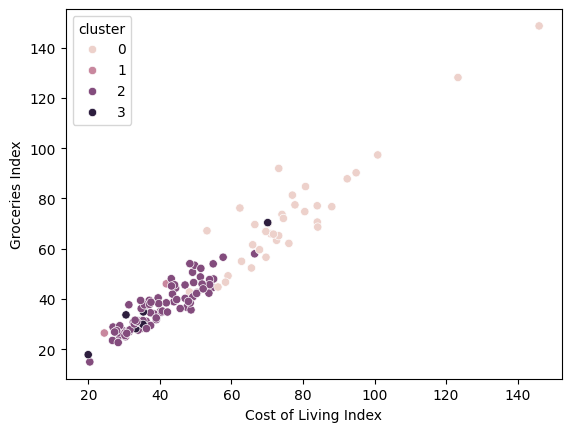

In [287]:
sns.scatterplot(x= df['Cost of Living Index'], y= df['Groceries Index'], hue='cluster', data=df)
plt.show()

---
$Insight:$
- It seems that the countries marked as cluster 0, have a higher cost of living and groceries index, meanwhile the countries marked as cluster 2 have a lowe cost of living and groceries index.
- Countries marked as cluster 1 and 3 seems to be the minority and therefore is hard to see from the entire dataset visualization, let's visualize them by their clusters now.

In [288]:
df_0 = df[df['cluster'] == 0]
df_1 = df[df['cluster'] == 1]
df_2 = df[df['cluster'] == 2]
df_3 = df[df['cluster'] == 3]

####Cluster 0 Analysis

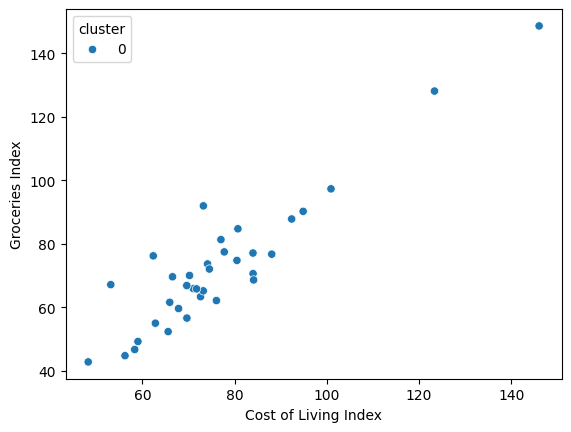

In [289]:
sns.scatterplot(x= df_0['Cost of Living Index'], y= df_0['Groceries Index'], hue='cluster', data=df_0)
plt.show()

In [290]:
df_0.head()

,Country,Country code,Continental Region,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Average Price per 1GB (USD),Population,cluster
5,Australia,AU,OCEANIA,77.75,36.84,77.44,72.95,104.63,0.70,24898152,0
6,Austria,AT,WESTERN EUROPE,71.04,27.13,65.88,66.03,77.25,1.17,8891388,0
8,Bahamas,BS,CARIBBEAN,84.00,35.34,70.59,89.09,45.07,5.98,385637,0
11,Barbados,BB,CARIBBEAN,92.37,21.99,87.81,78.18,32.08,6.79,286641,0
13,Belgium,BE,WESTERN EUROPE,72.61,25.79,63.32,78.63,79.72,5.28,11482178,0


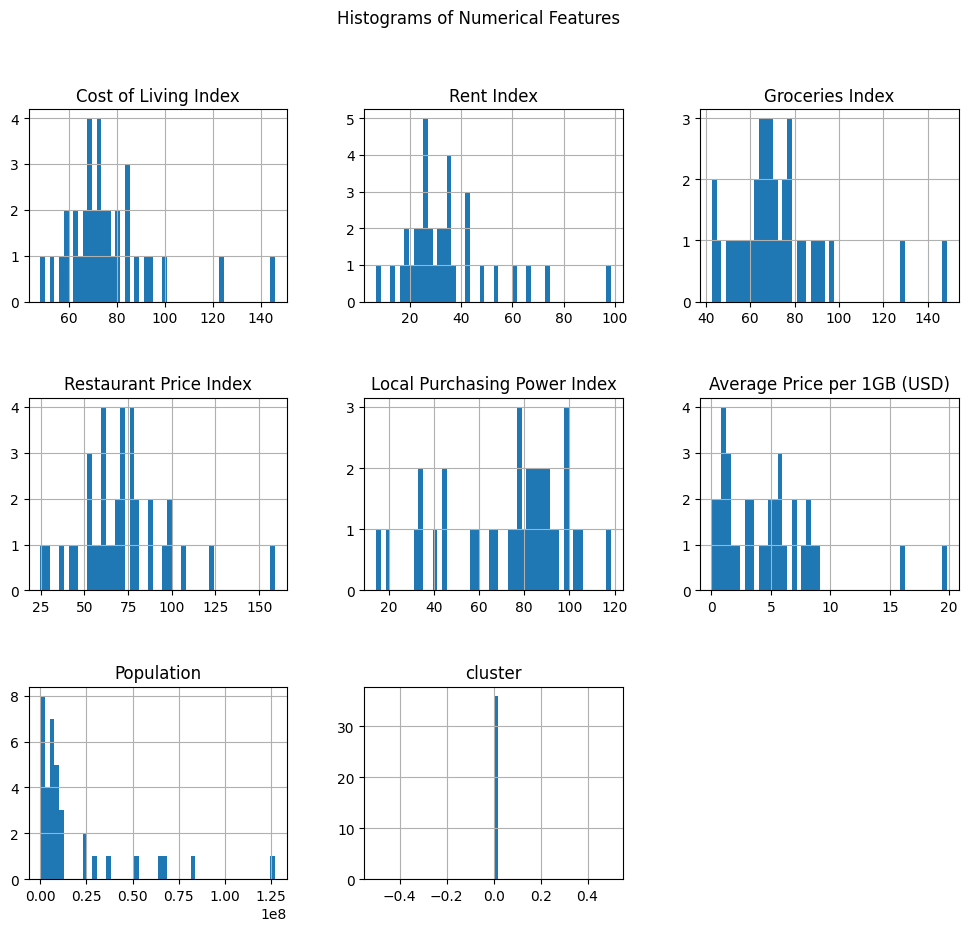

In [291]:
# Visualize the distribution of numerical features (histograms)
df_0.hist(bins=50, figsize=(12, 10))
plt.suptitle('Histograms of Numerical Features')
plt.subplots_adjust(hspace=0.5)
plt.show()

In [292]:
# Display summary statistics of numerical columns
print(df_0.describe())

       Cost of Living Index  Rent Index  Groceries Index  \
count             36.000000   36.000000        36.000000   
mean              76.257778   34.356111        72.448611   
std               18.528846   18.049852        20.928571   
min               48.240000    6.710000        42.760000   
25%               66.380000   24.810000        61.962500   
50%               72.905000   30.780000        69.100000   
75%               81.527500   38.112500        77.170000   
max              146.040000   98.580000       148.660000   

       Restaurant Price Index  Local Purchasing Power Index  \
count               36.000000                     36.000000   
mean                71.709722                     73.399722   
std                 25.642886                     25.542088   
min                 24.740000                     14.410000   
25%                 57.835000                     58.090000   
50%                 70.945000                     80.395000   
75%               

In [293]:
# Display basic information about the dataset (columns, data types, non-null counts)
print(df_0.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 5 to 135
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       36 non-null     object 
 1   Country code                  36 non-null     object 
 2   Continental Region            36 non-null     object 
 3   Cost of Living Index          36 non-null     float64
 4   Rent Index                    36 non-null     float64
 5   Groceries Index               36 non-null     float64
 6   Restaurant Price Index        36 non-null     float64
 7   Local Purchasing Power Index  36 non-null     float64
 8   Average Price per 1GB (USD)   36 non-null     float64
 9   Population                    36 non-null     int64  
 10  cluster                       36 non-null     int32  
dtypes: float64(6), int32(1), int64(1), object(3)
memory usage: 3.2+ KB
None


In [333]:
df_0['Country'].unique()

array(['Australia', 'Austria', 'Bahamas', 'Barbados', 'Belgium',
       'Bermuda', 'Canada', 'Cyprus', 'Czech Republic', 'Denmark',
       'Finland', 'France', 'Germany', 'Greece', 'Hong Kong', 'Iceland',
       'Ireland', 'Israel', 'Japan', 'Lebanon', 'Luxembourg', 'Malta',
       'New Zealand', 'Norway', 'Puerto Rico', 'Qatar', 'Seychelles',
       'Singapore', 'South Korea', 'Sweden', 'Switzerland', 'Taiwan',
       'United Arab Emirates', 'United Kingdom', 'Yemen'], dtype=object)

In [295]:
df_0['Continental Region'].value_counts()

WESTERN EUROPE          15
NEAR EAST                7
ASIA (EX. NEAR EAST)     5
CARIBBEAN                3
OCEANIA                  2
NORTHERN AMERICA         2
EASTERN EUROPE           1
SUB-SAHARAN AFRICA       1
Name: Continental Region, dtype: int64

In [296]:
df_0.mean(axis=0)

<ipython-input-296-c860ff6ec441>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_0.mean(axis=0)


Cost of Living Index            7.625778e+01
Rent Index                      3.435611e+01
Groceries Index                 7.244861e+01
Restaurant Price Index          7.170972e+01
Local Purchasing Power Index    7.339972e+01
Average Price per 1GB (USD)     4.749444e+00
Population                      1.800375e+07
cluster                         0.000000e+00
dtype: float64

####Cluster 1 Analysis

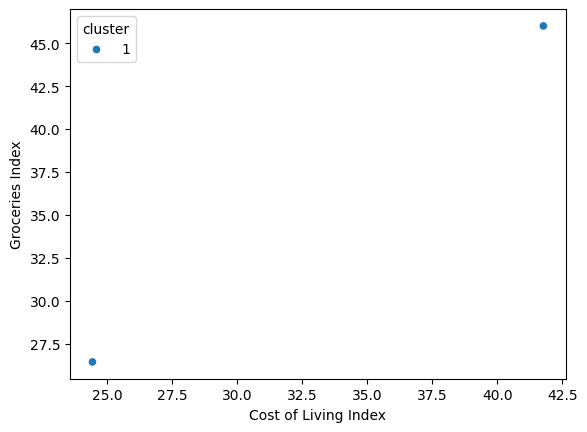

In [297]:
sns.scatterplot(x= df_1['Cost of Living Index'], y= df_1['Groceries Index'], hue='cluster', data=df_1)
plt.show()

In [298]:
df_1.head()

,Country,Country code,Continental Region,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Average Price per 1GB (USD),Population,cluster
25,China,CN,ASIA (EX. NEAR EAST),41.77,16.53,46.01,28.37,59.99,0.52,1427647786,1
52,India,IN,ASIA (EX. NEAR EAST),24.43,5.30,26.43,17.56,49.72,0.68,1352642280,1


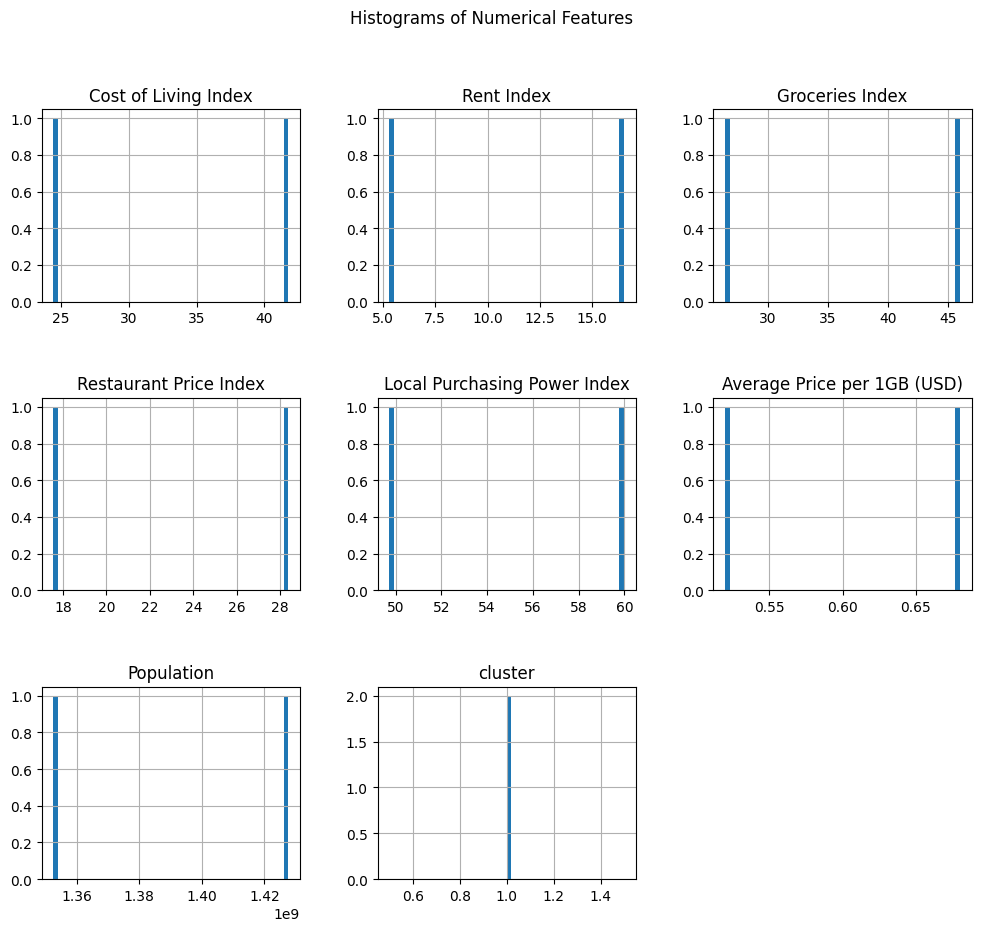

In [299]:
# Visualize the distribution of numerical features (histograms)
df_1.hist(bins=50, figsize=(12, 10))
plt.suptitle('Histograms of Numerical Features')
plt.subplots_adjust(hspace=0.5)
plt.show()

In [300]:
# Display summary statistics of numerical columns
print(df_1.describe())

       Cost of Living Index  Rent Index  Groceries Index  \
count              2.000000    2.000000         2.000000   
mean              33.100000   10.915000        36.220000   
std               12.261232    7.940809        13.845151   
min               24.430000    5.300000        26.430000   
25%               28.765000    8.107500        31.325000   
50%               33.100000   10.915000        36.220000   
75%               37.435000   13.722500        41.115000   
max               41.770000   16.530000        46.010000   

       Restaurant Price Index  Local Purchasing Power Index  \
count                2.000000                      2.000000   
mean                22.965000                     54.855000   
std                  7.643824                      7.261987   
min                 17.560000                     49.720000   
25%                 20.262500                     52.287500   
50%                 22.965000                     54.855000   
75%               

In [301]:
# Display basic information about the dataset (columns, data types, non-null counts)
print(df_1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 25 to 52
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       2 non-null      object 
 1   Country code                  2 non-null      object 
 2   Continental Region            2 non-null      object 
 3   Cost of Living Index          2 non-null      float64
 4   Rent Index                    2 non-null      float64
 5   Groceries Index               2 non-null      float64
 6   Restaurant Price Index        2 non-null      float64
 7   Local Purchasing Power Index  2 non-null      float64
 8   Average Price per 1GB (USD)   2 non-null      float64
 9   Population                    2 non-null      int64  
 10  cluster                       2 non-null      int32  
dtypes: float64(6), int32(1), int64(1), object(3)
memory usage: 184.0+ bytes
None


In [334]:
df_1['Country'].unique()

array(['China', 'India'], dtype=object)

In [303]:
df_1['Continental Region'].value_counts()

ASIA (EX. NEAR EAST)    2
Name: Continental Region, dtype: int64

In [304]:
df_1.mean()

<ipython-input-304-7bc3338caab0>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_1.mean()


Cost of Living Index            3.310000e+01
Rent Index                      1.091500e+01
Groceries Index                 3.622000e+01
Restaurant Price Index          2.296500e+01
Local Purchasing Power Index    5.485500e+01
Average Price per 1GB (USD)     6.000000e-01
Population                      1.390145e+09
cluster                         1.000000e+00
dtype: float64

####Cluster 2 Analysis

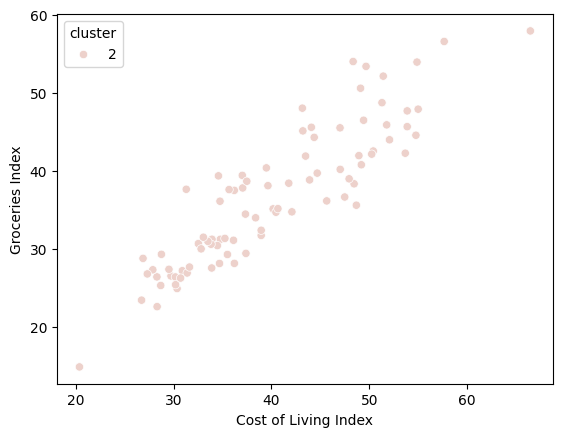

In [305]:
sns.scatterplot(x= df_2['Cost of Living Index'], y= df_2['Groceries Index'], hue='cluster', data=df_2)
plt.show()

In [306]:
df_2.head()

,Country,Country code,Continental Region,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Average Price per 1GB (USD),Population,cluster
0,Afghanistan,AF,ASIA (EX. NEAR EAST),20.37,2.72,14.92,12.41,23.04,1.02,37171921,2
1,Albania,AL,EASTERN EUROPE,35.50,8.47,29.32,25.82,30.19,2.80,2882740,2
2,Algeria,DZ,NORTHERN AFRICA,26.87,4.59,28.82,14.48,24.63,0.51,42228408,2
3,Argentina,AR,SOUTH AMERICA,34.69,7.71,28.17,33.32,30.72,2.38,44361150,2
4,Armenia,AM,CIS (FORMER USSR),33.89,11.61,27.59,30.55,28.86,0.76,2951745,2


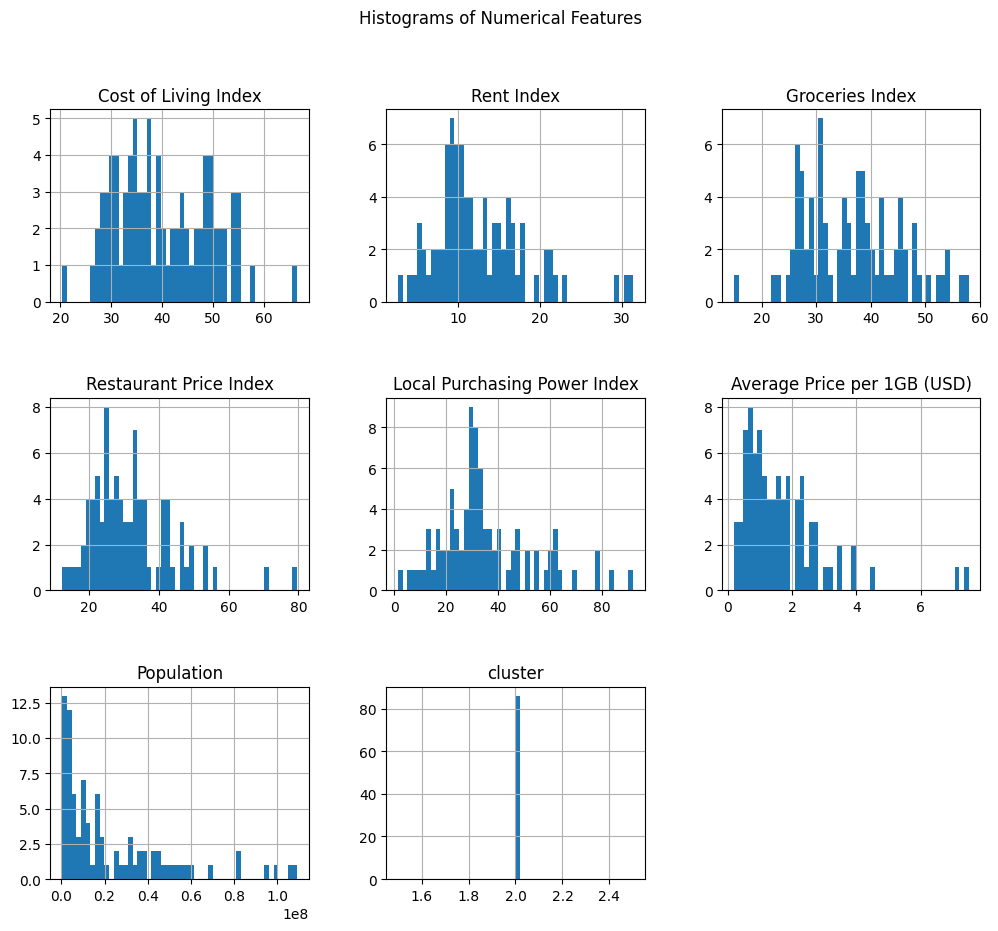

In [307]:
# Visualize the distribution of numerical features (histograms)
df_2.hist(bins=50, figsize=(12, 10))
plt.suptitle('Histograms of Numerical Features')
plt.subplots_adjust(hspace=0.5)
plt.show()

In [308]:
# Display summary statistics of numerical columns
print(df_2.describe())

       Cost of Living Index  Rent Index  Groceries Index  \
count             86.000000   86.000000        86.000000   
mean              40.103140   12.573953        36.572209   
std                9.125045    5.573587         8.836815   
min               20.370000    2.720000        14.920000   
25%               33.155000    9.100000        29.370000   
50%               38.665000   11.250000        36.160000   
75%               48.247500   15.660000        42.260000   
max               66.470000   31.310000        57.950000   

       Restaurant Price Index  Local Purchasing Power Index  \
count               86.000000                     86.000000   
mean                32.167442                     35.087907   
std                 11.770105                     17.896894   
min                 12.410000                      1.450000   
25%                 24.295000                     23.672500   
50%                 29.630000                     31.660000   
75%               

In [309]:
# Display basic information about the dataset (columns, data types, non-null counts)
print(df_2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86 entries, 0 to 136
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       86 non-null     object 
 1   Country code                  86 non-null     object 
 2   Continental Region            86 non-null     object 
 3   Cost of Living Index          86 non-null     float64
 4   Rent Index                    86 non-null     float64
 5   Groceries Index               86 non-null     float64
 6   Restaurant Price Index        86 non-null     float64
 7   Local Purchasing Power Index  86 non-null     float64
 8   Average Price per 1GB (USD)   86 non-null     float64
 9   Population                    86 non-null     int64  
 10  cluster                       86 non-null     int32  
dtypes: float64(6), int32(1), int64(1), object(3)
memory usage: 7.7+ KB
None


In [335]:
df_2['Country'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Argentina', 'Armenia',
       'Azerbaijan', 'Bahrain', 'Belarus', 'Belize', 'Bolivia',
       'Bosnia And Herzegovina', 'Botswana', 'Bulgaria', 'Cambodia',
       'Cameroon', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia',
       'Ethiopia', 'Fiji', 'Georgia', 'Ghana', 'Guatemala', 'Honduras',
       'Hungary', 'Iran', 'Iraq', 'Italy', 'Ivory Coast', 'Jamaica',
       'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Libya',
       'Lithuania', 'Malaysia', 'Maldives', 'Mauritius', 'Moldova',
       'Mongolia', 'Montenegro', 'Morocco', 'Myanmar', 'Nepal',
       'Nicaragua', 'North Macedonia', 'Oman', 'Panama', 'Paraguay',
       'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Rwanda',
       'Saudi Arabia', 'Senegal', 'Serbia', 'Slovakia', 'Slovenia',
       'Somalia', 'South Africa', 'Spain', 'Sri Lanka', 'Suriname',
       'Syria', 'Tanzania', 'Th

In [311]:
df_2['Continental Region'].value_counts()

SUB-SAHARAN AFRICA      14
EASTERN EUROPE          13
ASIA (EX. NEAR EAST)    12
SOUTH AMERICA            9
NEAR EAST                8
CIS (FORMER USSR)        7
CENTRAL AMERICA          7
NORTHERN AFRICA          5
CARIBBEAN                4
BALTICS                  3
WESTERN EUROPE           3
OCEANIA                  1
Name: Continental Region, dtype: int64

In [312]:
df_2.mean()

<ipython-input-312-909f24cde2f9>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_2.mean()


Cost of Living Index            4.010314e+01
Rent Index                      1.257395e+01
Groceries Index                 3.657221e+01
Restaurant Price Index          3.216744e+01
Local Purchasing Power Index    3.508791e+01
Average Price per 1GB (USD)     1.662791e+00
Population                      2.333456e+07
cluster                         2.000000e+00
dtype: float64

####Cluster 3 Analysis

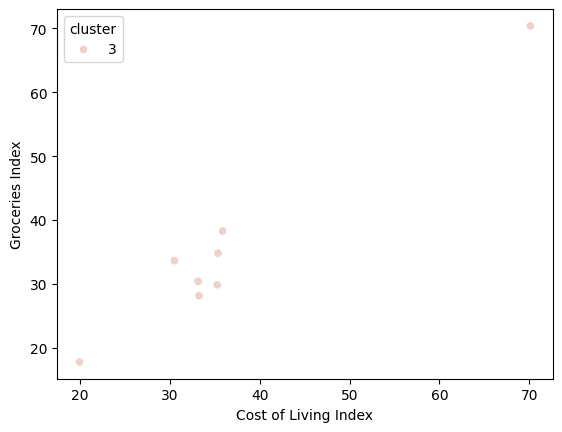

In [313]:
sns.scatterplot(x= df_3['Cost of Living Index'], y= df_3['Groceries Index'], hue='cluster', data=df_3)
plt.show()

In [314]:
df_3.head()

,Country,Country code,Continental Region,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Average Price per 1GB (USD),Population,cluster
10,Bangladesh,BD,ASIA (EX. NEAR EAST),33.13,4.42,30.41,21.70,25.30,0.34,166303498,3
19,Brazil,BR,SOUTH AMERICA,33.24,8.27,28.16,25.24,27.85,0.92,209469323,3
53,Indonesia,ID,ASIA (EX. NEAR EAST),35.85,9.82,38.29,17.74,21.07,0.42,267670543,3
78,Mexico,MX,CENTRAL AMERICA,35.35,12.55,34.82,32.67,38.62,3.62,128972439,3
88,Nigeria,NG,SUB-SAHARAN AFRICA,30.49,35.99,33.65,20.92,9.34,0.88,195874685,3


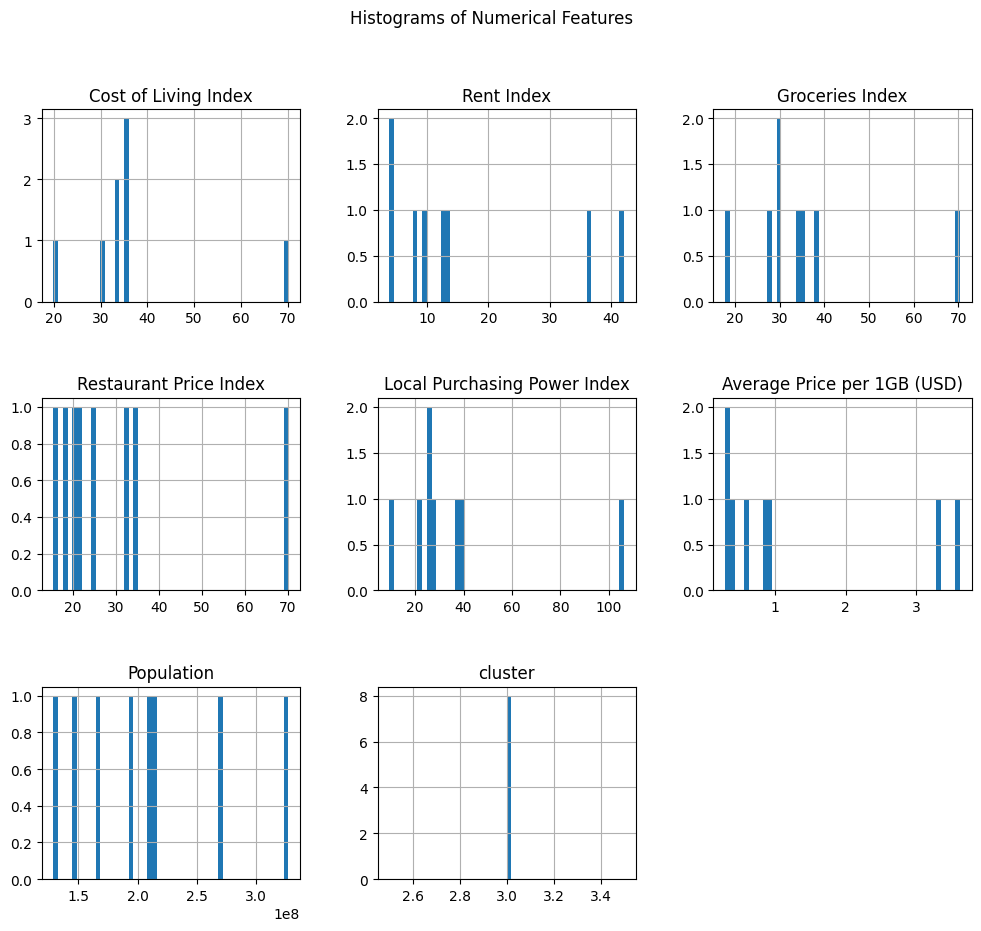

In [315]:
# Visualize the distribution of numerical features (histograms)
df_3.hist(bins=50, figsize=(12, 10))
plt.suptitle('Histograms of Numerical Features')
plt.subplots_adjust(hspace=0.5)
plt.show()

In [316]:
# Display summary statistics of numerical columns
print(df_3.describe())

       Cost of Living Index  Rent Index  Groceries Index  \
count               8.00000    8.000000         8.000000   
mean               36.67125   16.265000        35.421250   
std                14.47671   14.527135        15.362597   
min                19.92000    3.910000        17.810000   
25%                32.47000    7.307500        29.435000   
50%                34.25000   11.185000        32.030000   
75%                35.47500   18.815000        35.687500   
max                70.13000   42.070000        70.370000   

       Restaurant Price Index  Local Purchasing Power Index  \
count                8.000000                      8.000000   
mean                29.805000                     36.570000   
std                 17.593085                     29.655977   
min                 15.540000                      9.340000   
25%                 20.125000                     24.242500   
50%                 23.470000                     27.240000   
75%               

In [317]:
# Display basic information about the dataset (columns, data types, non-null counts)
print(df_3.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 10 to 131
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       8 non-null      object 
 1   Country code                  8 non-null      object 
 2   Continental Region            8 non-null      object 
 3   Cost of Living Index          8 non-null      float64
 4   Rent Index                    8 non-null      float64
 5   Groceries Index               8 non-null      float64
 6   Restaurant Price Index        8 non-null      float64
 7   Local Purchasing Power Index  8 non-null      float64
 8   Average Price per 1GB (USD)   8 non-null      float64
 9   Population                    8 non-null      int64  
 10  cluster                       8 non-null      int32  
dtypes: float64(6), int32(1), int64(1), object(3)
memory usage: 736.0+ bytes
None


In [336]:
df_3['Country'].unique()

array(['Bangladesh', 'Brazil', 'Indonesia', 'Mexico', 'Nigeria',
       'Pakistan', 'Russia', 'United States'], dtype=object)

In [319]:
df_3['Continental Region'].value_counts()

ASIA (EX. NEAR EAST)    3
SOUTH AMERICA           1
CENTRAL AMERICA         1
SUB-SAHARAN AFRICA      1
CIS (FORMER USSR)       1
NORTHERN AMERICA        1
Name: Continental Region, dtype: int64

In [320]:
df_3.mean()

<ipython-input-320-fc3afd635618>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_3.mean()


Cost of Living Index            3.667125e+01
Rent Index                      1.626500e+01
Groceries Index                 3.542125e+01
Restaurant Price Index          2.980500e+01
Local Purchasing Power Index    3.657000e+01
Average Price per 1GB (USD)     1.298750e+00
Population                      2.068596e+08
cluster                         3.000000e+00
dtype: float64

---
#Conclusion

Now let's see which country is the most fitting to move into. We will see based on their cluster's characteristic first.

In [321]:
df_0_mean = pd.DataFrame(df_0.mean(numeric_only=True))
df_1_mean = pd.DataFrame(df_1.mean(numeric_only=True))
df_2_mean = pd.DataFrame(df_2.mean(numeric_only=True))
df_3_mean = pd.DataFrame(df_3.mean(numeric_only=True))

In [322]:
df_0_mean.T

,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Average Price per 1GB (USD),Population,cluster
0,76.257778,34.356111,72.448611,71.709722,73.399722,4.749444,1.800375e+07,0.0


In [323]:
df_1_mean.T

,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Average Price per 1GB (USD),Population,cluster
0,33.1,10.915,36.22,22.965,54.855,0.6,1.390145e+09,1.0


In [324]:
df_2_mean.T

,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Average Price per 1GB (USD),Population,cluster
0,40.10314,12.573953,36.572209,32.167442,35.087907,1.662791,2.333456e+07,2.0


In [325]:
df_3_mean.T

,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Average Price per 1GB (USD),Population,cluster
0,36.67125,16.265,35.42125,29.805,36.57,1.29875,2.068596e+08,3.0


---
$Insight:$
- **Cluster 0** : Consists of mostly countries with high Cost of living, rent, restaurant price, and local purchasing power indexes. It also has the highest price of internet and mostly consists of developed countries, bar a few exceptions.
- **Cluster 1** : Consists of the 2 most populated countries in the world, China and India, they have the cheapest cost of living, rent, etc. indexes, minus the higher than average local purchasing power index. They also have the cheapest internet cost.
- **Cluster 2** : Consists mostly of countries in SUB-SAHARAN AFRICA, EASTERN EUROPE, ASIA (EX. NEAR EAST), and SOUTH AMERICA. This cluster have just about average in almost every aspect, hence the high amount of countries identified as cluster 2. Cluster 2 have no noticeable characteristics besides having more countries than the other clusters.
- **Cluster 3** : Consists mostly of developing countries with the exception of USA and Russia. This cluster features high population count, a lower than average cost of living, groceries, restaurant, and internet prices. Though it has a higher than average rent and local purchasing power indexes.
- **Conclusion** : **India** is a suitable location to move to, since it has one of the the lowest average costs of living, rent, groceries, restaurant, and internet.

---
#Model Inference

Now let's add a new country "Landia" and see which cluster it belongs to.

In [326]:
X = df.drop('cluster', axis=1)
y = df['cluster']

In [327]:
X

,Country,Country code,Continental Region,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Average Price per 1GB (USD),Population
0,Afghanistan,AF,ASIA (EX. NEAR EAST),20.37,2.72,14.92,12.41,23.04,1.02,37171921
1,Albania,AL,EASTERN EUROPE,35.50,8.47,29.32,25.82,30.19,2.80,2882740
2,Algeria,DZ,NORTHERN AFRICA,26.87,4.59,28.82,14.48,24.63,0.51,42228408
3,Argentina,AR,SOUTH AMERICA,34.69,7.71,28.17,33.32,30.72,2.38,44361150
4,Armenia,AM,CIS (FORMER USSR),33.89,11.61,27.59,30.55,28.86,0.76,2951745
...,...,...,...,...,...,...,...,...,...,...
132,Uruguay,UY,SOUTH AMERICA,52.07,13.93,44.01,49.39,30.07,1.51,3449285
133,Uzbekistan,UZ,CIS (FORMER USSR),27.31,9.29,26.83,24.22,22.37,0.60,32476244
134,Vietnam,VN,ASIA (EX. NEAR EAST),37.48,13.22,38.70,19.98,29.38,0.49,95545962
135,Yemen,YE,NEAR EAST,53.14,6.71,67.12,24.74,14.41,15.98,28498683


In [328]:
X_new = pd.DataFrame()
X_new = X.copy()
X_new = X_new.drop(axis=0, index=X_new.index)

In [329]:
new_values_dict = {
    'Country': 'Landia',
    'Country code': 'LD',
    'Continental Region': 'CIS (FORMER USSR)',
    'Cost of Living Index': 26.87,
    'Rent Index': 9.29,
    'Groceries Index': 31.53,
    'Restaurant Price Index': 12.41,
    'Local Purchasing Power Index': 22.37,
    'Average Price per 1GB (USD)': 15.98,
    'Population': 7777777
}

# Append new row to X_new
X_new = X_new.append(new_values_dict, ignore_index=True)
X_new_scaled = X_new.drop("Country", axis=1).drop("Country code", axis=1).drop("Continental Region", axis=1)

<ipython-input-329-b79856e7a06d>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_new = X_new.append(new_values_dict, ignore_index=True)


In [330]:
X_new

,Country,Country code,Continental Region,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Average Price per 1GB (USD),Population
0,Landia,LD,CIS (FORMER USSR),26.87,9.29,31.53,12.41,22.37,15.98,7777777


In [331]:
X_new_scaled = scaler.fit_transform(X_new_scaled)

X_new_scaled_pca = pca.transform(X_new_scaled)

predicted_cluster = km.predict(X_new_scaled_pca)

print(f"The new data is in cluster :{predicted_cluster}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


The new data is in cluster :[2]


---
$Insight:$
- Our imaginary Country "Landia" seems to belong in cluster 2, so it has an average survivability.